In [79]:
# Imports
import os
import requests
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import hvplot.pandas
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import quantstats as qs
%matplotlib inline

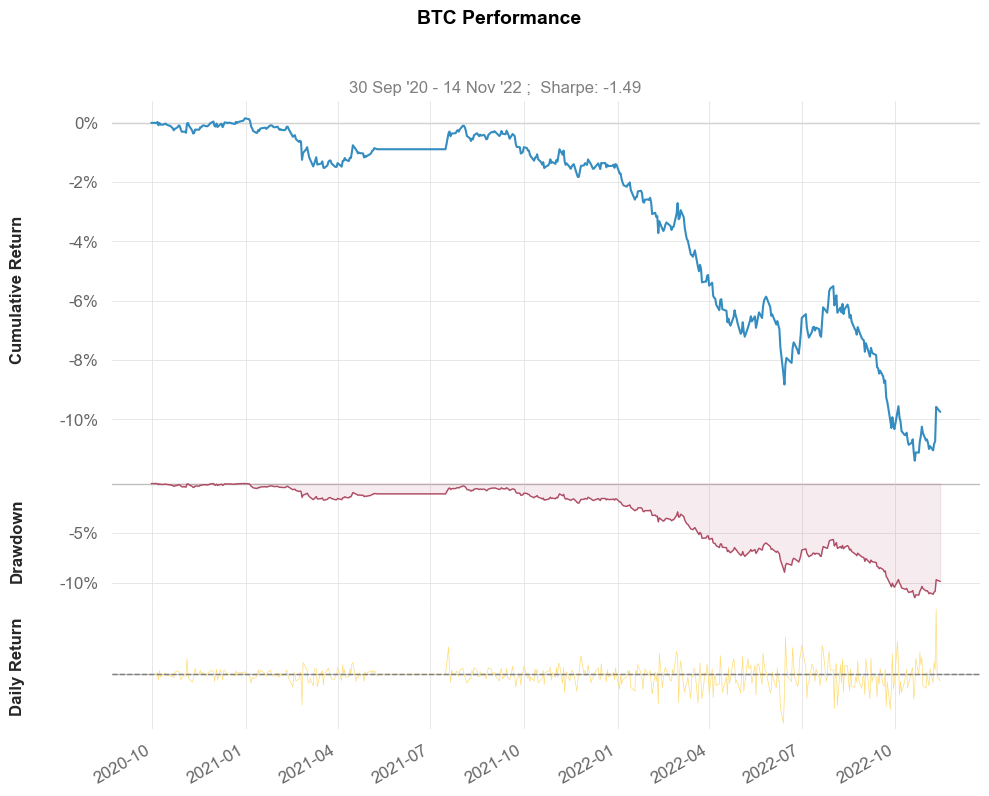

In [80]:
# Creating Charts from a quantstats library
# From library extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
stock = qs.utils.download_returns('BTC')

# show sharpe ratio
qs.stats.sharpe(stock)

# or using extend_pandas()
stock.sharpe()

# Plot 
qs.plots.snapshot(stock, title='BTC Performance')

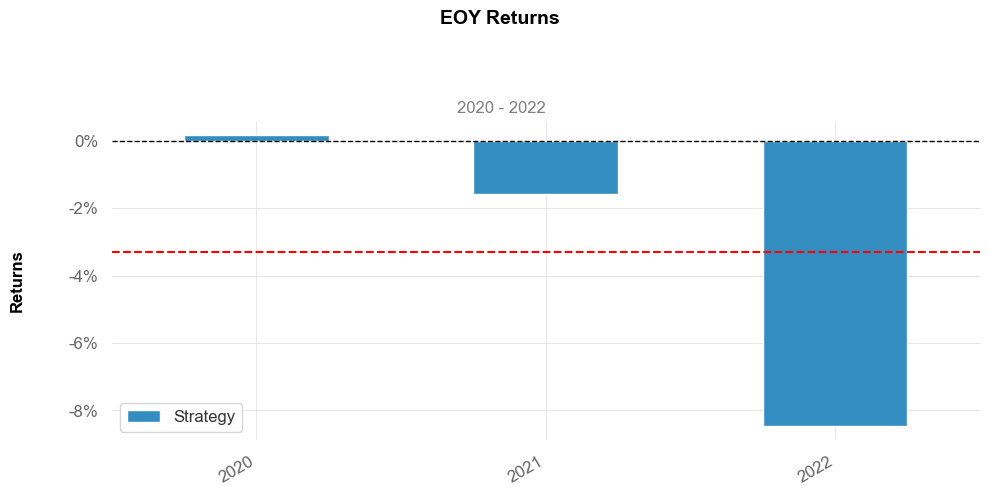

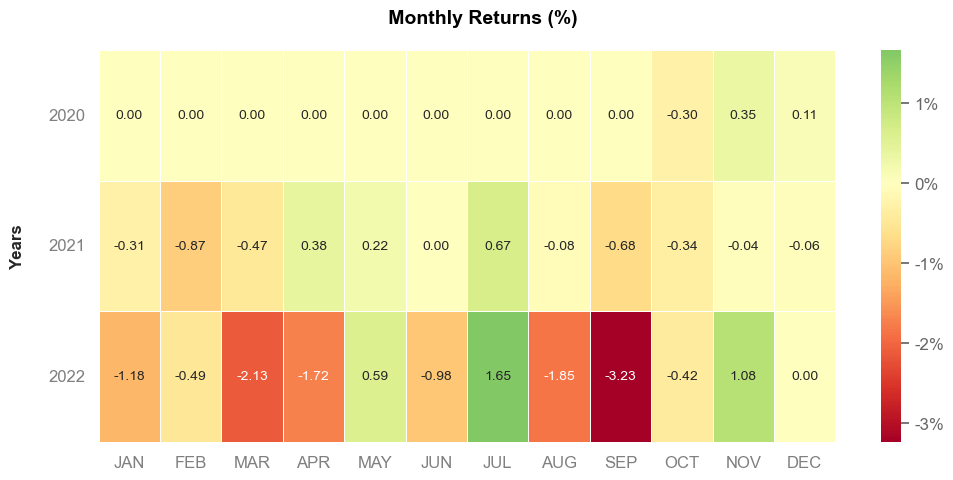

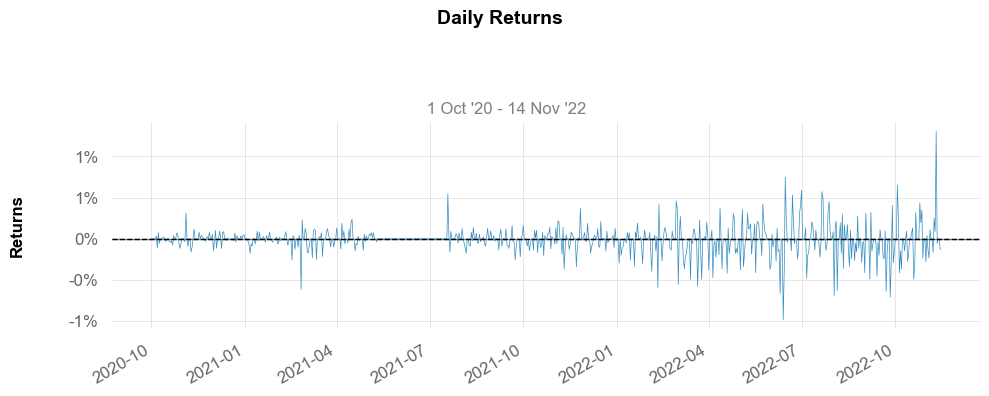

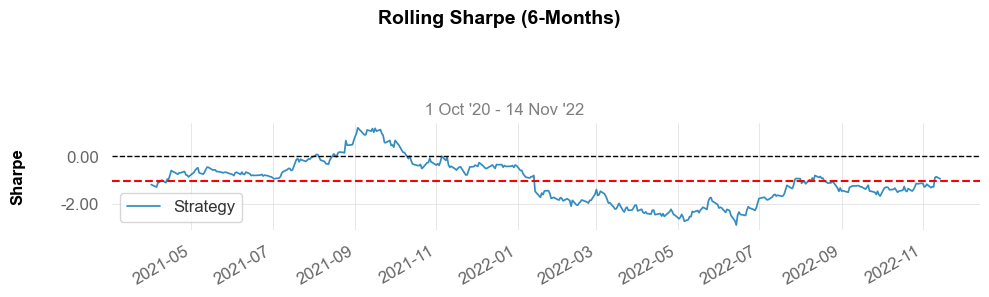

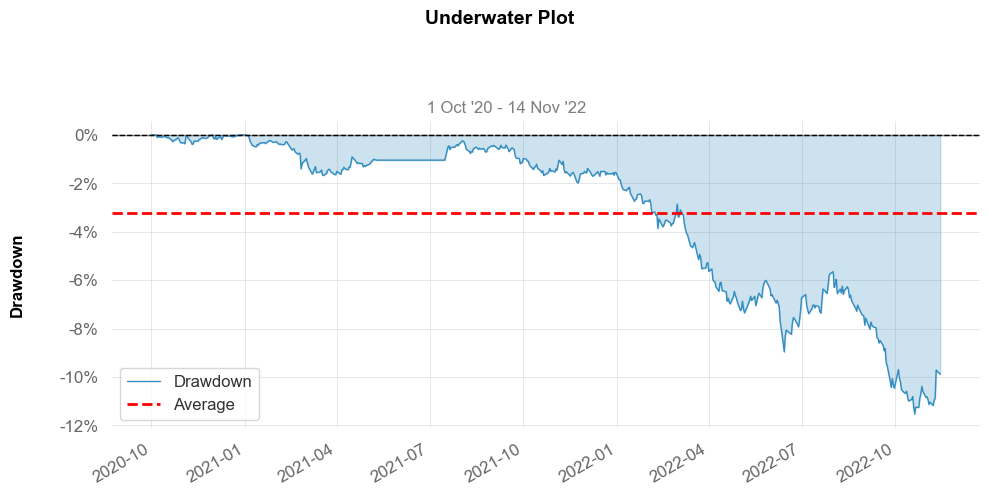

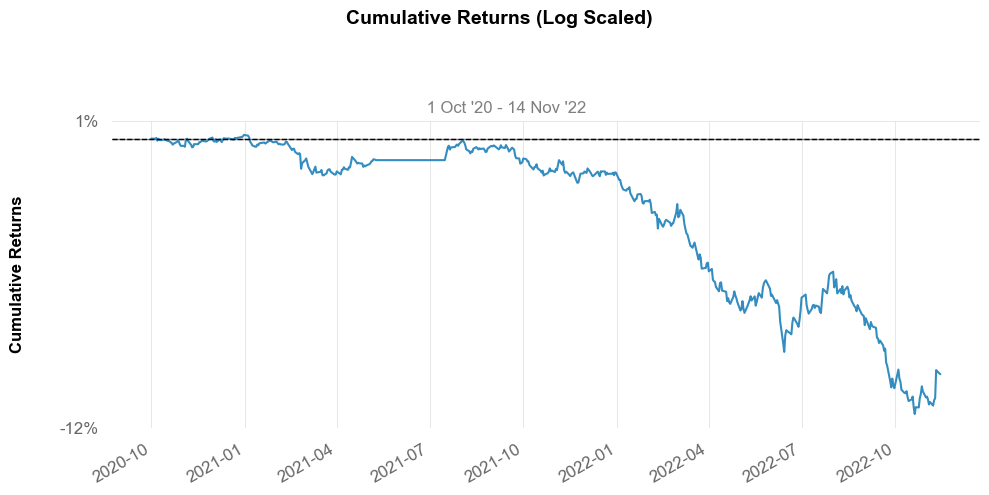

In [81]:
# Create 6 charts from the quantstats
qs.plots.yearly_returns(stock)
qs.plots.monthly_heatmap(stock)
qs.plots.daily_returns(stock)
qs.plots.rolling_sharpe(stock)
qs.plots.drawdown(stock)
qs.plots.log_returns(stock)


In [82]:
# Load .env enviroment variables
load_dotenv()

True

In [83]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [84]:
# Pulling Crypto Information and store in datframe
# Format current date as ISO format
today = pd.Timestamp("2021-1-1", tz="America/New_York").isoformat()

# Set the tickers BTCUSD (bitcoin), ETHUSD (Ethereum), and TRXUSD (Tron)
tickers = ["BTCUSD", "ETHUSD","TRXUSD"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for crypto

df_crypto = alpaca.get_crypto_bars(
    tickers,
    timeframe,
    start = today
).df


In [85]:
# Reorganize the crypto DataFrame and clean up data
# 
BTC = df_crypto[df_crypto['symbol']=='BTCUSD'].drop('symbol', axis=1)
BTC['BTC Return'] = BTC['close'].pct_change()
BTC = BTC.drop(columns= ['exchange','open','volume', 'trade_count', 'vwap'])

ETH = df_crypto[df_crypto['symbol']=='ETHUSD'].drop('symbol', axis=1)
ETH['ETH Return'] = ETH['close'].pct_change()
ETH = ETH.drop(columns= ['exchange','open','volume', 'trade_count', 'vwap'])

TRX = df_crypto[df_crypto['symbol']=='TRXUSD'].drop('symbol', axis=1)
TRX['TRX Return'] = TRX['close'].pct_change()
TRX = TRX.drop(columns= ['exchange','open','volume', 'trade_count', 'vwap'])

# Concatenate the ticker DataFrames
df_crypto = pd.concat([BTC, ETH, TRX],axis=1, keys=['BTC','ETH', 'TRX']).dropna()

df_crypto.head()

BTC                                     ETH  \
                               high       low     close BTC Return     high   
timestamp                                                                     
2021-01-26 06:00:00+00:00  32584.62  31420.69  31551.72  -0.022773  1375.91   
2021-01-26 06:00:00+00:00  32830.00  30900.00  31526.00  -0.000815  1372.00   
2021-01-27 06:00:00+00:00  31936.16  29200.00  30407.13  -0.035490  1312.56   
2021-01-27 06:00:00+00:00  31719.00  29275.00  31622.00   0.039953  1304.20   
2021-01-28 06:00:00+00:00  34433.04  32729.00  33052.81   0.045247  1378.00   

                                                             TRX            \
                               low    close ETH Return      high       low   
timestamp                                                                    
2021-01-26 06:00:00+00:00  1276.00  1286.15  -0.041474  0.029550  0.028700   
2021-01-26 06:00:00+00:00  1245.00  1282.00  -0.003227  0.029550  0.028700   
2021-01-27 06:00:00+00:00  1206.05  1240.96  -0.032012  0.028735  0.028385   
2021-01-27 06:00:00+00:00  1220.00  1304.20   0.050961  0.028735  0.028385   
2021-01-28 06:00:00+00:00  1286.56  1305.38   0.000905  0.030818  0.029510   

                                                
                              close TRX Return  
timestamp                                       
2021-01-26 06:00:00+00:00  0.028700  -0.030815  
2021-01-26 06:00:00+00:00  0.028700  -0.030815  
2021-01-27 06:00:00+00:00  0.028735   0.001220  
2021-01-27 06:00:00+00:00  0.028735   0.001220  
2021-01-28 06:00:00+00:00  0.030818   0.072473

In [86]:
# Pulling Stock Information and store in datframe
# Format current date as ISO format
today = pd.Timestamp("2021-1-24", tz="America/New_York").isoformat()

# Set the stock_tickers to TSLA , GME, and SPY
stock_tickers = ["TSLA", "GME","SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and GOOGL
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock = alpaca.get_bars(
    stock_tickers,
    timeframe,
    start = today
).df

In [87]:
# Reorganize the stocd DataFrame
# Separate ticker data
TSLA = df_stock[df_stock['symbol']=='TSLA'].drop('symbol', axis=1)
TSLA['TSLA Return'] = TSLA['close'].pct_change().dropna()
TSLA = TSLA.drop(columns= ['open','volume', 'trade_count', 'vwap'])

GME = df_stock [df_stock['symbol']=='GME'].drop('symbol', axis=1)
GME['GME Return'] = GME['close'].pct_change().dropna()
GME = GME.drop(columns= ['open','volume', 'trade_count', 'vwap'])

SPY = df_stock [df_stock['symbol']=='SPY'].drop('symbol', axis=1)
SPY['SPY Return'] = SPY['close'].pct_change().dropna()
SPY = SPY.drop(columns= ['open','volume', 'trade_count', 'vwap'])

# Concatenate the ticker DataFrames
df_stock = pd.concat([TSLA, GME, SPY],axis=1, keys=['TSLA','GME', 'SPY']).dropna()
df_stock.head()

TSLA                                   GME  \
                             high       low   close TSLA Return    high   
timestamp                                                                 
2021-01-26 05:00:00+00:00  895.90  871.6000  883.09    0.002600  150.00   
2021-01-27 05:00:00+00:00  891.50  858.6600  864.16   -0.021436  380.00   
2021-01-28 05:00:00+00:00  848.00  801.0000  835.43   -0.033246  483.00   
2021-01-29 05:00:00+00:00  842.41  780.1000  793.53   -0.050154  413.98   
2021-02-01 05:00:00+00:00  842.00  795.5601  839.81    0.058322  322.00   

                                                         SPY                   \
                              low   close GME Return    high      low   close   
timestamp                                                                       
2021-01-26 05:00:00+00:00   80.20  147.98   0.927074  385.85  383.540  383.75   
2021-01-27 05:00:00+00:00  249.00  347.51   1.348358  380.32  372.010  374.65   
2021-01-28 05:00:00+00:00  112.25  193.60  -0.442894  381.93  375.890  377.52   
2021-01-29 05:00:00+00:00  250.00  325.00   0.678719  376.67  368.270  370.14   
2021-02-01 05:00:00+00:00  212.00  225.00  -0.307692  377.34  370.376  376.02   

                                      
                          SPY Return  
timestamp                             
2021-01-26 05:00:00+00:00  -0.002054  
2021-01-27 05:00:00+00:00  -0.023713  
2021-01-28 05:00:00+00:00   0.007660  
2021-01-29 05:00:00+00:00  -0.019549  
2021-02-01 05:00:00+00:00   0.015886

In [90]:
# Drawdown chart

# Trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 252 days data have an expanding window
roll_max = df_crypto['BTC']['close'].rolling(window, min_periods=1).max()
daily_drawdown = df_crypto['BTC']['close']/roll_max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
d = daily_drawdown.hvplot(legend = False, hover_color = "yellow")
md = max_daily_drawdown.hvplot(title = "BTC Max Daily Drawdown", legend= False, hover_color = "green")

#overlay both daily drawdown and max daily drawdown
d*md

:Overlay
   .Curve.Close.I  :Curve   [timestamp]   (close)
   .Curve.Close.II :Curve   [timestamp]   (close)

In [91]:
#Combine crypto and stock returns
df_crypto_return =  pd.concat([df_crypto['BTC']['BTC Return'], df_crypto['ETH']['ETH Return'],df_crypto['TRX']['TRX Return']], axis=1)
df_stock_return = pd.concat([df_stock['TSLA']['TSLA Return'], df_stock['GME']['GME Return'], df_stock['SPY']['SPY Return']], axis =1)

# Calculate the log return
df_log_return = np.log(1 + df_crypto_return)
df_log_return_stock = np.log(1 + df_stock_return)

# overlay the two charts
crypto_log = df_log_return.hvplot(title = "Log Daily Return")
stock_log = df_log_return_stock.hvplot()
stock_log * crypto_log

:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)

In [92]:
# Display Crypto and Stock
display(df_crypto_return.tail())
display(df_stock_return.tail())

,BTC Return,ETH Return,TRX Return
timestamp,,,
2022-11-14 06:00:00+00:00,0.000001,0.000465,0.075594
2022-11-14 06:00:00+00:00,-0.000800,0.000297,0.075594
2022-11-15 06:00:00+00:00,0.013422,0.005179,0.010040
2022-11-15 06:00:00+00:00,0.000141,0.000072,0.010040
2022-11-15 06:00:00+00:00,-0.000665,-0.000383,0.010040


,TSLA Return,GME Return,SPY Return
timestamp,,,
2022-11-09 05:00:00+00:00,-0.071668,-0.080748,-0.020602
2022-11-10 05:00:00+00:00,0.073934,0.076590,0.054954
2022-11-11 05:00:00+00:00,0.027527,0.049035,0.009678
2022-11-14 05:00:00+00:00,-0.025616,-0.001916,-0.008507
2022-11-15 05:00:00+00:00,0.018382,0.059117,0.008478


In [93]:
# Plot the daily returns
c = df_crypto_return.hvplot(kind="line", title = "Daily Returns")
s = df_stock_return.hvplot(kind="line")
c * s

:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)

In [94]:
#Calculate cumulative returns for crypto and stocks
df_cumulative_returns = (1 + df_crypto_return).cumprod()
df_cumulative_stock_returns = (1 + df_stock_return).cumprod()


# Plot the chart
c = df_cumulative_returns.hvplot(title = "Cumulative Returns")
s = df_cumulative_stock_returns.hvplot()
c*s

:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)

In [95]:
#Plot box chart
c = df_crypto_return.hvplot.box( title = "Daily Return Box", legend = False)
s = df_stock_return.hvplot.box(legend = False)
c*s

:Overlay
   .BoxWhisker.I  :BoxWhisker   [Variable]   (value)
   .BoxWhisker.II :BoxWhisker   [Variable]   (value)

In [96]:
#calculate STDs
all_stds = df_crypto_return.std()
stock_stds = df_stock_return.std()
all_stds = pd.concat([all_stds, stock_stds], axis=0)
all_stds.hvplot.bar(legend = False, title = "STDs")

:Bars   [index]   (0)

In [97]:
#Volatity
volatility = all_stds * np.sqrt(365)
volatility.hvplot.line(title = "Volatility")

:Curve   [index]   (0)

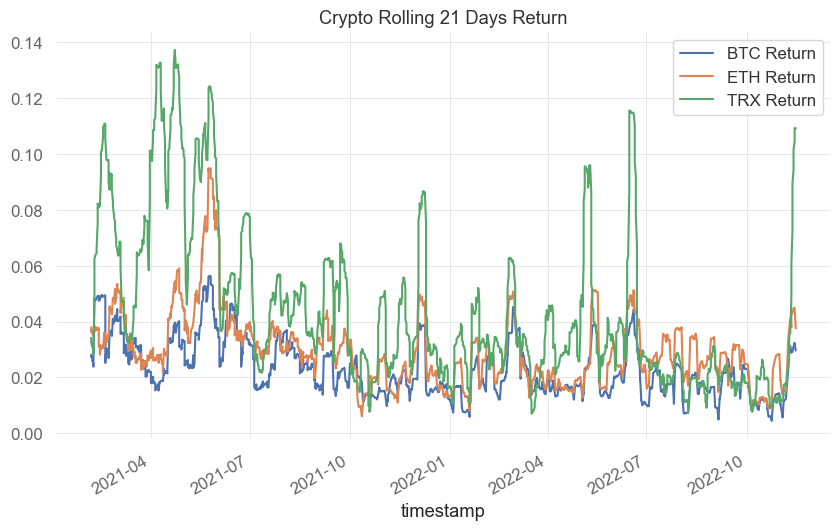

In [98]:
#Plot rolling window
rolling_21 = df_crypto_return.rolling(window=21).std().plot(title = "Crypto Rolling 21 Days Return")

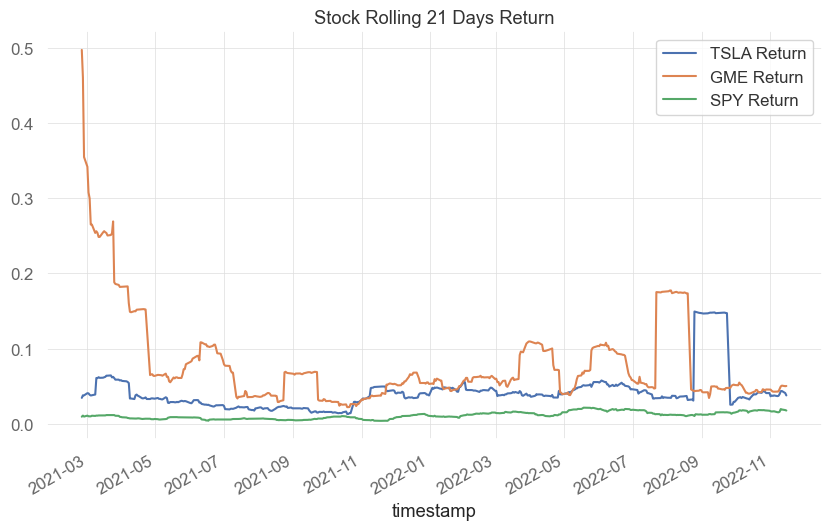

In [99]:
#Plot rolling
rolling_21 = df_stock_return.rolling(window=21).std().plot(title = "Stock Rolling 21 Days Return")

<AxesSubplot:>

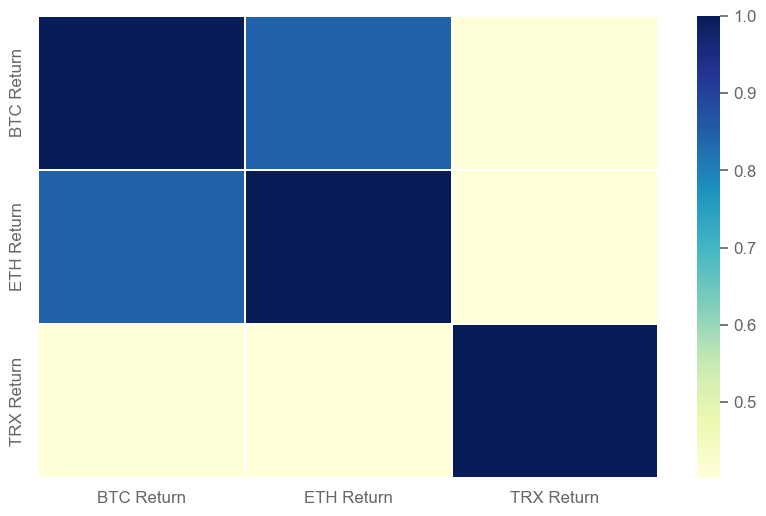

In [108]:
#Calculate correlation and plot heatmap

#correlation = pd.concat([df_crypto_return,df_stock_return], axis=1)
display(sns.heatmap(df_crypto_return.corr(), cmap ="YlGnBu", linewidths = 0.1))




<AxesSubplot:>

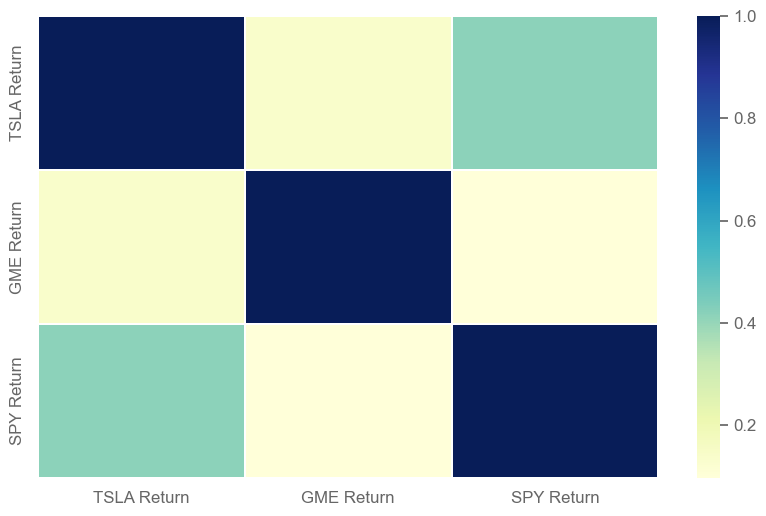

In [107]:
# Correlations
display(sns.heatmap(df_stock_return.corr(), cmap ="YlGnBu", linewidths = 0.1))

<AxesSubplot:title={'center':'GME 21-Day Rolling Covariance vs SP500'}, xlabel='timestamp'>

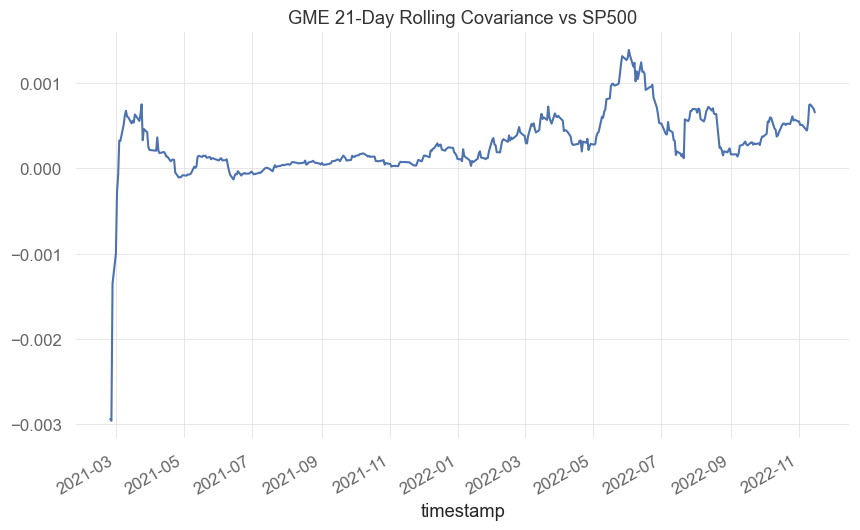

In [101]:
#Calculate GME Rolling Covariance vs SP500
covariance = df_stock_return['GME Return'].cov(df_stock_return['SPY Return'])

variance = df_stock_return['SPY Return'].var()
GME_beta = covariance / variance
rolling_covariance = df_stock_return['GME Return'].rolling(window=21).cov(df_stock_return['SPY Return'])
rolling_covariance.plot(title="GME 21-Day Rolling Covariance vs SP500")

<AxesSubplot:title={'center':'TRX 21-Day Rolling Covariance vs ETH'}, xlabel='timestamp'>

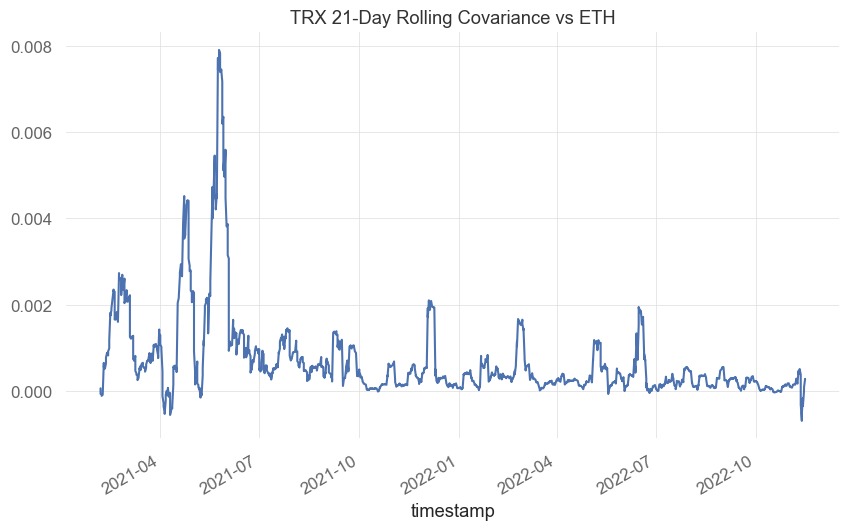

In [102]:
# Calculate the covariance for TRX and ETH
covariance2 = df_crypto_return['TRX Return'].cov(df_crypto_return['ETH Return'])

variance2 = df_crypto_return['ETH Return'].var()
TRX_beta2 = covariance2 / variance2
rolling_covariance2 = df_crypto_return['TRX Return'].rolling(window=21)

rolling_covariance2 = df_crypto_return['TRX Return'].rolling(window=21).cov(df_crypto_return['ETH Return'])

#Plot the chart
rolling_covariance2.plot(title="TRX 21-Day Rolling Covariance vs ETH")

<AxesSubplot:xlabel='timestamp'>

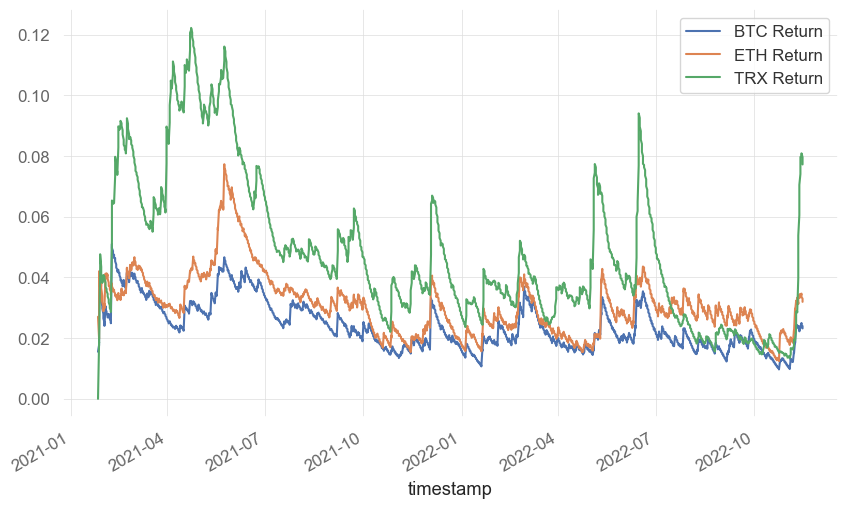

In [103]:
#Calculate ewm and plot it
ewm = df_crypto_return.ewm(halflife=21).std().dropna()
ewm.plot()

<AxesSubplot:title={'center':'BTC Rolling Sharpe - 6 Months'}, xlabel='timestamp'>

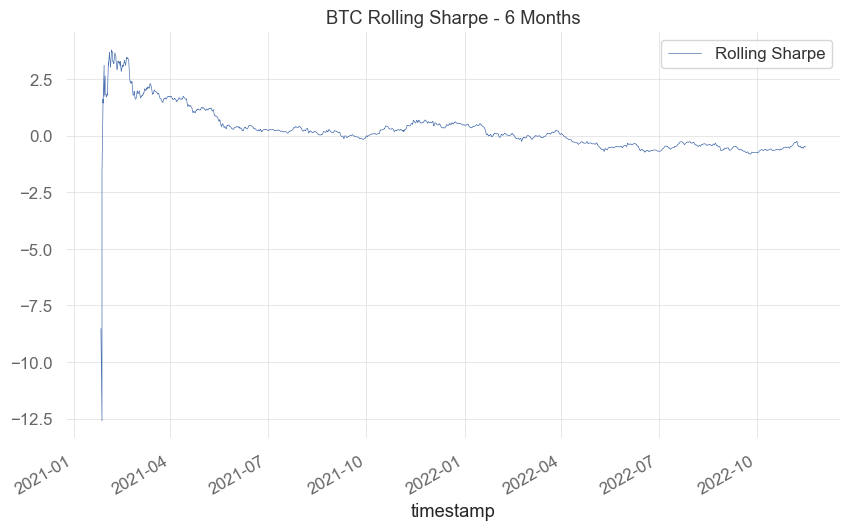

In [104]:
def my_rolling_sharpe(y):
    return np.sqrt(126) * (y.mean() / y.std()) # 21 days per month X 6 months = 126

df_c_return = pd.DataFrame()

df_c_return['Rolling Sharpe'] = df_crypto_return['BTC Return'].rolling('180d').apply(my_rolling_sharpe)

df_c_return.plot(y=['Rolling Sharpe'], linewidth=0.5, title = "BTC Rolling Sharpe - 6 Months")

<AxesSubplot:title={'center':'ETH Rolling Sharpe - 6 Months'}, xlabel='timestamp'>

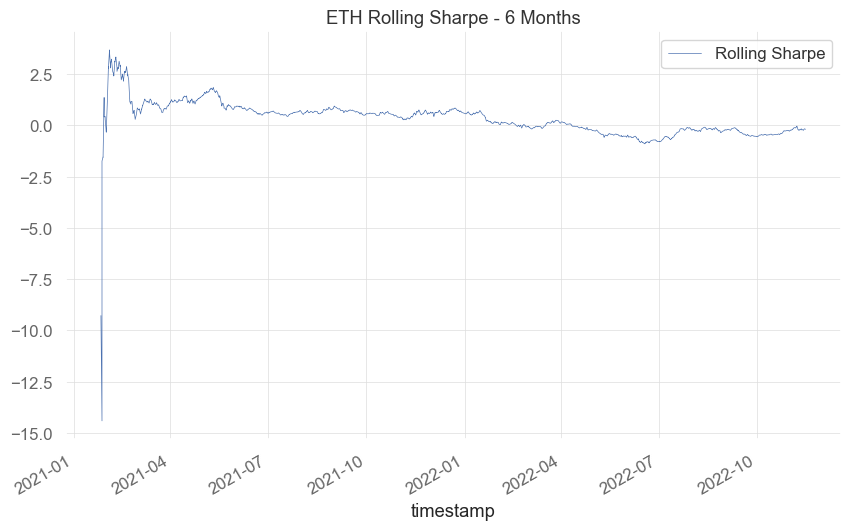

In [105]:
def my_rolling_sharpe(y):
    return np.sqrt(126) * (y.mean() / y.std()) # 21 days per month X 6 months = 126

df_e_return = pd.DataFrame()

df_e_return['Rolling Sharpe'] = df_crypto_return['ETH Return'].rolling('180d').apply(my_rolling_sharpe)

df_e_return.plot(y=['Rolling Sharpe'], linewidth=0.5, title = "ETH Rolling Sharpe - 6 Months")

In [ ]:
# Calculate the Sharpe ratios
sharpe_crypto_ratios = (df_crypto_return.mean() * 252) / (df_crypto_return.std() * np.sqrt(252))
sharpe_stock_ratios = (df_stock_return.mean() * 252) / (df_stock_return.std() * np.sqrt(252))


# Plot Sharpe ratios for crypto and stocks
c = sharpe_crypto_ratios.hvplot.bar(title = "Sharpe Ratios", hover_fill_color="orange", legend = False)
s = sharpe_stock_ratios.hvplot.bar(hover_color= "orange", legend= False)
c*s

In [ ]:
# Monthly returns
sp_data_daily_returns = df_stock['SPY']['close'].pct_change()
sp_data_monthly_returns = df_stock['SPY']['close'].resample('M').ffill().pct_change().dropna()
sp_data_yearly_returns =df_stock['TSLA']['close'].resample('A').ffill().pct_change().dropna()

#convert to Dataframe
sp_data_monthly_returns = pd.DataFrame(sp_data_monthly_returns)
sp_data_monthly_returns.index = sp_data_monthly_returns.index.date


sp_data_monthly_returns['year'] = pd.DatetimeIndex(sp_data_monthly_returns.index).year
sp_data_monthly_returns['month'] = pd.DatetimeIndex(sp_data_monthly_returns.index).month
sp_data_monthly_returns.set_index('year')
#sp_data_monthly_returns.hvplot.heatmap(x_sampling=sp_data_monthly_returns['month'], y_sampling = sp_data_monthly_returns['year'])
#sns.heatmap(sp_data_monthly_returns, xtick=sp_data_monthly_returns.groupby('month'), ytick=sp_data_monthly_returns.groupby('year'), cmap='RdYlGn')


#sns.heatmap(per_change, annot=True, fmt="", cmap='RdYlGn', ax=ax)
#sp_data_monthly_returns.hvplot.heatmap(x= sp_data_monthly_returns['month'], y= sp_data_monthly_returns['year'])


#sns.heatmap(sp_data_monthly_returns, annot=True, fmt="", cmap='RdYlGn')

:Overlay
   .Bars.A_0.I  :Bars   [index]   (0)
   .Bars.A_0.II :Bars   [index]   (0)